In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers
tfb = tfp.bijectors
print("TF version:", tf.__version__)
print("TFP version:", tfp.__version__)

TF version: 2.3.1
TFP version: 0.11.1


# Variational autoencoders

## Coding tutorials

#### [1. Encoders and decoders](#tutorial1)
#### [2. Minimising Kullback-Leibler divergence](#tutorial2)
#### [3. Maximising the ELBO](#tutorial3)
#### [4. KL divergence layers](#tutorial4)

***
<a class="anchor" id="tutorial1"></a>
## Encoders and decoders

In [2]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Reshape
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
# Load Fashion MNIST

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.astype('float32')/255.
x_test = x_test.astype('float32')/255.
class_names = np.array(['T-shirt/top', 'Trouser/pants', 'Pullover shirt', 'Dress',
                        'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag','Ankle boot'])

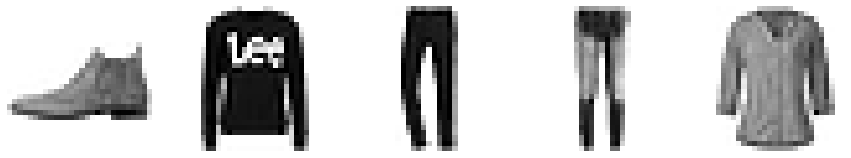

In [4]:
# Display a few examples

n_examples = 1000
example_images = x_test[0:n_examples]
example_labels = y_test[0:n_examples]

f, axs = plt.subplots(1, 5, figsize=(15, 4))
for j in range(len(axs)):
    axs[j].imshow(example_images[j], cmap='binary')
    axs[j].axis('off')

In [5]:
# Define the encoder
encoded_dim = 2 

encoder = Sequential([
                        Flatten(input_shape=(28,28)),
                        Dense(256, activation = 'sigmoid'),
                        Dense(64, activation = 'sigmoid'),
                        Dense(encoded_dim)
])


In [6]:
# Encode examples before training
pretrain_example_encodings = encoder(example_images).numpy()


/home/ankdesh/virtualenvs/tf-probablity-host/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


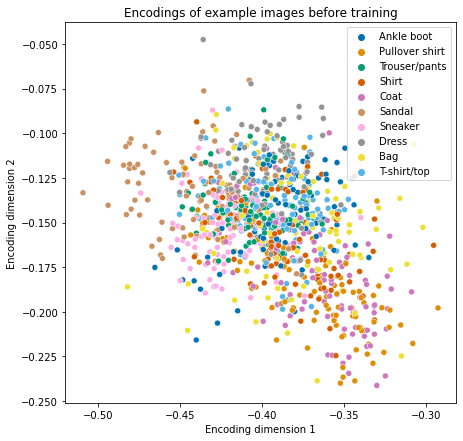

In [7]:
# Plot encoded examples before training 

f, ax = plt.subplots(1, 1, figsize=(7, 7))
sns.scatterplot(pretrain_example_encodings[:, 0],
                pretrain_example_encodings[:, 1],
                hue=class_names[example_labels], ax=ax,
                palette=sns.color_palette("colorblind", 10));
ax.set_xlabel('Encoding dimension 1'); ax.set_ylabel('Encoding dimension 2')
ax.set_title('Encodings of example images before training');

In [8]:
# Define the decoder
decoder = Sequential([
                        Dense(64, activation ='sigmoid', input_shape = (encoded_dim,)),
                        Dense(256, activation = 'sigmoid'),
                        Dense(28*28, activation = 'sigmoid'),
                        Reshape((28,28))
])


In [12]:
# Compile and fit the model

autoencoder = Model(inputs=encoder.inputs, outputs=decoder(encoder.outputs))

# Specify loss - input and output is in [0., 1.], so we can use a binary cross-entropy loss
autoencoder.compile(loss='binary_crossentropy')

# Fit model - highlight that labels and input are the same
autoencoder.fit(x=x_train, y=x_train, epochs=10, batch_size=32)


Epoch 1/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.4038
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3408
Epoch 3/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3325
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3284
Epoch 5/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3259
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3242
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3230
Epoch 8/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3220
Epoch 9/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3214
Epoch 10/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3206


In [13]:
# Compute example encodings after training

posttrain_example_encodings = encoder(example_images).numpy()

/home/ankdesh/virtualenvs/tf-probablity-host/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ankdesh/virtualenvs/tf-probablity-host/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


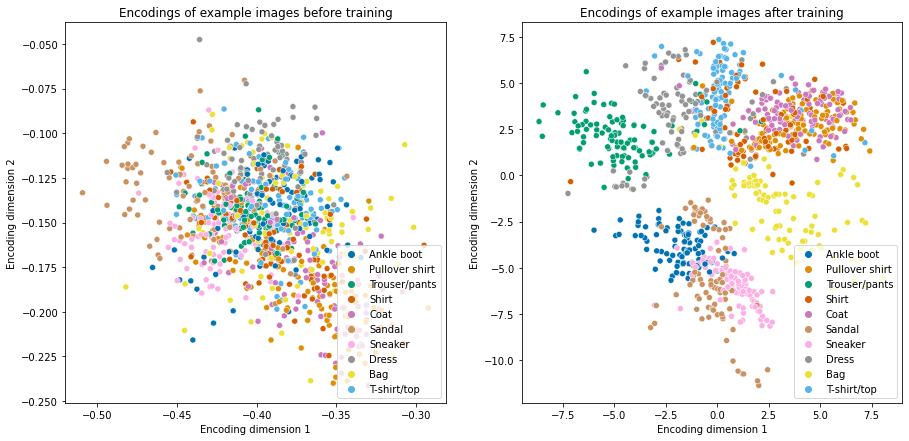

In [14]:
# Compare the example encodings before and after training

f, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
sns.scatterplot(pretrain_example_encodings[:, 0],
                pretrain_example_encodings[:, 1],
                hue=class_names[example_labels], ax=axs[0],
                palette=sns.color_palette("colorblind", 10));
sns.scatterplot(posttrain_example_encodings[:, 0],
                posttrain_example_encodings[:, 1],
                hue=class_names[example_labels], ax=axs[1],
                palette=sns.color_palette("colorblind", 10));

axs[0].set_title('Encodings of example images before training');
axs[1].set_title('Encodings of example images after training');

for ax in axs: 
    ax.set_xlabel('Encoding dimension 1')
    ax.set_ylabel('Encoding dimension 2')
    ax.legend(loc='lower right')

In [15]:
# Compute the autoencoder's reconstructions

reconstructed_example_images = autoencoder(example_images)

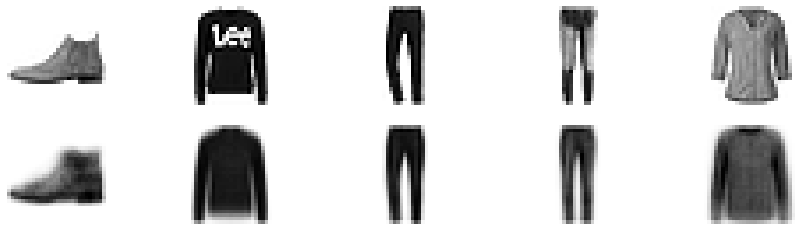

In [16]:
# Evaluate the autoencoder's reconstructions

f, axs = plt.subplots(2, 5, figsize=(15, 4))
for j in range(5):
    axs[0, j].imshow(example_images[j], cmap='binary')
    axs[1, j].imshow(reconstructed_example_images[j].numpy().squeeze(), cmap='binary')
    axs[0, j].axis('off')
    axs[1, j].axis('off')

***
<a class="anchor" id="tutorial2"></a>
## Minimising Kullback-Leibler divergence

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

In [18]:
# Define a target distribution, p
tf.random.set_seed(42)

p_mu = [0., 0.]

p_L = tfb.Chain([tfb.TransformDiagonal(tfb.Softplus()),
                tfb.FillTriangular()])(tf.random.uniform([3]))

p = tfd.MultivariateNormalTriL(loc=p_mu, scale_tril=p_L)

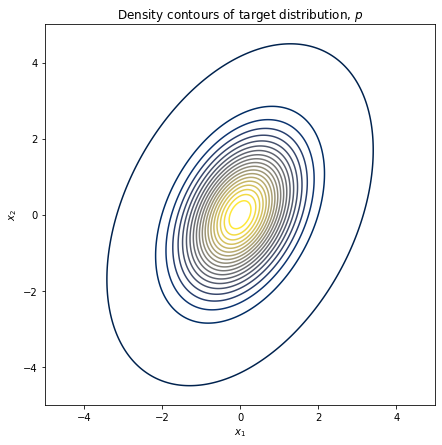

In [19]:
# Plot the target distribution's density contours

def plot_density_contours(density, X1, X2, contour_kwargs, ax=None):
    '''
        Plots the contours of a bivariate TensorFlow density function (i.e. .prob()).
        X1 and X2 are numpy arrays of mesh coordinates.
    '''
    X = np.hstack([X1.flatten()[:, np.newaxis], X2.flatten()[:, np.newaxis]])
    density_values = np.reshape(density(X).numpy(), newshape=X1.shape)
    
    if ax==None:
        _, ax = plt.subplots(figsize=(7, 7))
    
    ax.contour(X1, X2, density_values, **contour_kwargs)
    return(ax)

x1 = np.linspace(-5, 5, 1000)
x2 = np.linspace(-5, 5, 1000)
X1, X2 = np.meshgrid(x1, x2)
f, ax = plt.subplots(1, 1, figsize=(7, 7))

# Density contours are linearly spaced
contour_levels = np.linspace(1e-4, 10**(-0.8), 20) # specific to this seed
ax = plot_density_contours(p.prob, X1, X2, 
                           {'levels':contour_levels, 
                            'cmap':'cividis'}, ax=ax)
ax.set_xlim(-5, 5); ax.set_ylim(-5, 5); 
ax.set_title('Density contours of target distribution, $p$')
ax.set_xlabel('$x_1$'); ax.set_ylabel('$x_2$');

In [23]:
# Initialize an approximating distribution, q, that has diagonal covariance
from IPython.display import clear_output
tf.random.set_seed(41)

q = tfd.MultivariateNormalDiag(loc=tf.Variable(tf.random.normal([2])),
                               scale_diag=tfp.util.TransformedVariable(tf.random.uniform([2]),
                                                                       bijector=tfb.Exp()))


In [24]:
# Define a function for the Kullback-Leibler divergence

@tf.function
def loss_and_grads(dist_a, dist_b):
    with tf.GradientTape() as tape:
        loss = tfd.kl_divergence(dist_a, dist_b)
    return loss, tape.gradient(loss, dist_a.trainable_variables)

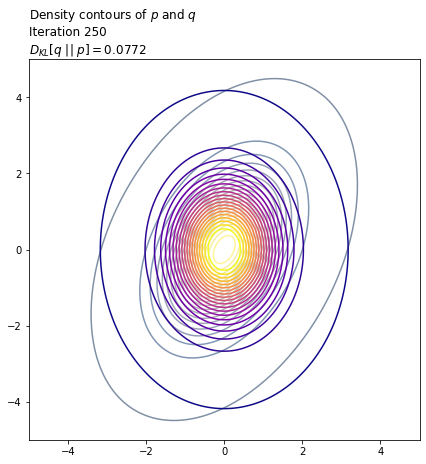

In [25]:
# Run a training loop that computes KL[q || p], updates q's parameters using its gradients

num_train_steps = 250
opt = tf.keras.optimizers.Adam(learning_rate=.01)
for i in range(num_train_steps):
    
    # Compute the KL divergence and its gradients
    q_loss, grads = loss_and_grads(q, p)
    
    # Update the trainable variables using the gradients via the optimizer
    opt.apply_gradients(zip(grads, q.trainable_variables))
    
    # Plot the updated density 
    if ((i + 1) % 10 == 0):
        clear_output(wait=True)
        ax = plot_density_contours(p.prob, X1, X2,
                                   {'levels':contour_levels,
                                    'cmap':'cividis', 'alpha':0.5})
        ax = plot_density_contours(q.prob, X1, X2, 
                                   {'levels':contour_levels,
                                    'cmap':'plasma'}, ax=ax)
        ax.set_title('Density contours of $p$ and $q$\n' +
                     'Iteration ' + str(i + 1) + '\n' +
                      '$D_{KL}[q \ || \ p] = ' + 
                      str(np.round(q_loss.numpy(), 4)) + '$',
                      loc='left')
        plt.pause(.01)

In [26]:
# Re-fit the distribution, this time fitting q_rev by minimising KL[p || q_rev]
tf.random.set_seed(41)

q_rev = tfd.MultivariateNormalDiag(loc=tf.Variable(tf.random.normal([2])),
                               scale_diag=tfp.util.TransformedVariable(tf.random.uniform([2]),
                                                                       bijector=tfb.Exp()))


In [27]:
# Edit loss_and_grads function
@tf.function
def loss_and_grads(dist_a, dist_b, reverse=False):
    with tf.GradientTape() as tape:
        if not reverse:
            loss = tfd.kl_divergence(dist_a, dist_b)
        else:
                loss = tfd.kl_divergence(dist_b, dist_a)
    return loss, tape.gradient(loss, dist_a.trainable_variables)

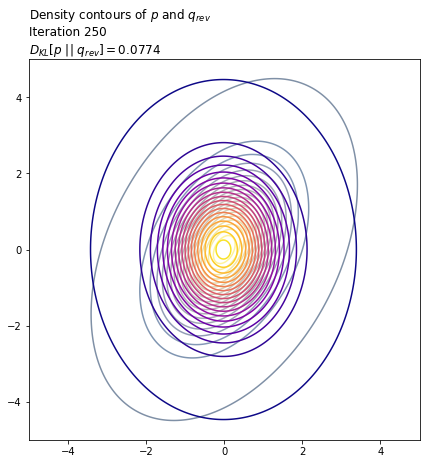

In [28]:
# Re-initialize optimizer, run training loop

opt = tf.keras.optimizers.Adam(learning_rate=.01)
for i in range(num_train_steps):
    # Reverse the KL divergence terms - compute KL[p || q_rev] 
    q_rev_loss, grads = loss_and_grads(q_rev, p, reverse=True)
    
    # Update the trainable variables using the gradients via the optimizer
    opt.apply_gradients(zip(grads, q_rev.trainable_variables))
    
    # Plot the updated density 
    if ((i + 1) % 10 == 0):
        clear_output(wait=True)
        ax = plot_density_contours(p.prob, X1, X2,
                                   {'levels':contour_levels,
                                    'cmap':'cividis', 'alpha':0.5})
        ax = plot_density_contours(q_rev.prob, X1, X2, 
                                   {'levels':contour_levels,
                                    'cmap':'plasma'}, ax=ax)
        ax.set_title('Density contours of $p$ and $q_{rev}$\n' +
                     'Iteration ' + str(i + 1) + '\n' +
                      '$D_{KL}[p \ || \ q_{rev}] = ' + 
                      str(np.round(q_rev_loss.numpy(), 4)) + '$',
                      loc='left')
        plt.pause(.01)

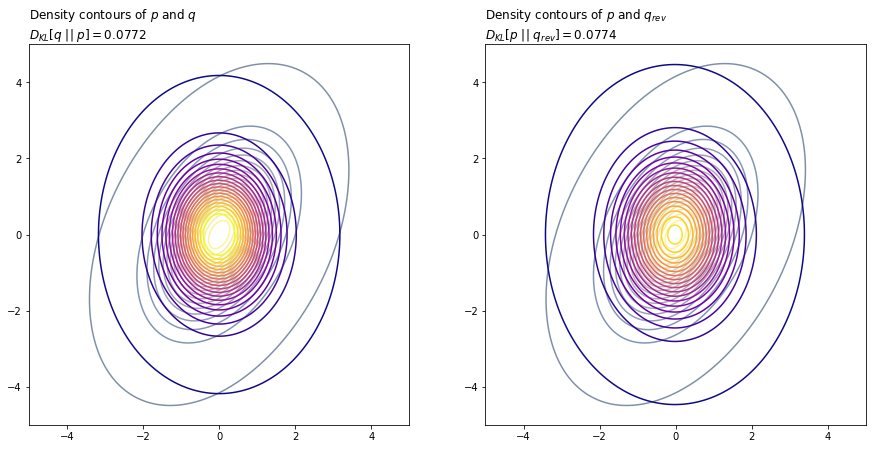

In [29]:
# Plot q and q_rev alongside one another

f, axs = plt.subplots(1, 2, figsize=(15, 7))

axs[0] = plot_density_contours(p.prob, X1, X2,
                           {'levels':contour_levels,
                            'cmap':'cividis', 'alpha':0.5}, ax=axs[0])
axs[0] = plot_density_contours(q.prob, X1, X2, 
                           {'levels':contour_levels,
                            'cmap':'plasma'}, ax=axs[0])
axs[0].set_title('Density contours of $p$ and $q$\n' +
              '$D_{KL}[q \ || \ p] = ' + str(np.round(q_loss.numpy(), 4)) + '$',
              loc='left')

axs[1] = plot_density_contours(p.prob, X1, X2,
                           {'levels':contour_levels,
                            'cmap':'cividis', 'alpha':0.5}, ax=axs[1])
axs[1] = plot_density_contours(q_rev.prob, X1, X2, 
                           {'levels':contour_levels,
                            'cmap':'plasma'}, ax=axs[1])
axs[1].set_title('Density contours of $p$ and $q_{rev}$\n' +
              '$D_{KL}[p \ || \ q_{rev}] = ' + str(np.round(q_rev_loss.numpy(), 4)) + '$',
              loc='left');

---
<a class="anchor" id="tutorial3"></a>
## Maximising the ELBO 

Review of terminology:
- $p(z)$ = prior
- $q(z|x)$ = encoding distribution
- $p(x|z)$ = decoding distribution

\begin{align}
\log p(x) &\geq \mathrm{E}_{Z \sim q(z | x)}\big[−\log q(Z | x) + \log p(x, Z)\big]\\
          &= - \mathrm{KL}\big[ \ q(z | x) \ || \ p(z) \ \big] + \mathrm{E}_{Z \sim q(z | x)}\big[\log p(x | Z)\big] 
\end{align}

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Reshape
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Import Fasion MNIST, make it a TensorFlow Dataset

(x_train, _), (x_test, _) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.astype('float32')/255.
x_test = x_test.astype('float32')/255.
example_x = x_test[:16]

batch_size = 64
x_train = tf.data.Dataset.from_tensor_slices(x_train).batch(batch_size)

In [ ]:
# Define the encoding distribution, q(z|x)

latent_size = 2
event_shape = (28,28)

encoder = sequential([
    Flatten(input_shape = event_shape),
    Dense(256, activation = 'relu'),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(32, activation = 'relu'),
    Dense(2*latent_size),
    tfpl.DistributionLambda(
        lambda t: tfd.MultivariateNormalDiag(loc = t[..., :latent_size],
                                            scale_diag=tf.math.exp(t[t..., latent_size:]))
    )
])


In [ ]:
# Pass an example image through the network - should return a batch of MultivariateNormalDiags.



In [ ]:
# Define the decoding distribution, p(x|z)



In [ ]:
# Pass a batch of examples to the decoder



In [ ]:
# Define the prior, p(z) - a standard bivariate Gaussian



The loss function we need to estimate is

\begin{equation}
-\mathrm{ELBO} = \mathrm{KL}[ \ q(z|x) \ || \ p(z) \ ] - \mathrm{E}_{Z \sim q(z|x)}[\log p(x|Z)]\\
\end{equation}

where $x = (x_1, x_2, \ldots, x_n)$ refers to all observations, $z = (z_1, z_2, \ldots, z_n)$ refers to corresponding latent variables.

Assumed independence of examples implies that we can write this as

\begin{equation}
\sum_j \mathrm{KL}[ \ q(z_j|x_j) \ || \ p(z_j) \ ] - \mathrm{E}_{Z_j \sim q(z_j|x_j)}[\log p(x_j|Z_j)]
\end{equation}

In [ ]:
# Specify the loss function, an estimate of the -ELBO



In [ ]:
# Define a function that returns the loss and its gradients



In [ ]:
# Compile and train the model

num_epochs = 5
opt = tf.keras.optimizers.Adam()
for i in range(num_epochs):
    for train_batch in x_train:
        current_loss, grads = get_loss_and_grads(train_batch)
        opt.apply_gradients(zip(grads, encoder.trainable_variables
                                       + decoder.trainable_variables))
        
    print('-ELBO after epoch {}: {:.0f}'.format(i+1, current_loss.numpy())

In [ ]:
# Connect encoder and decoder, compute a reconstruction



In [ ]:
# Plot examples against reconstructions

f, axs = plt.subplots(2, 6, figsize=(16, 5))

for j in range(6):
    axs[0, j].imshow(example_x[j, :, :].squeeze(), cmap='binary')
    axs[1, j].imshow(example_reconstruction[j, :, :], cmap='binary')
    axs[0, j].axis('off')
    axs[1, j].axis('off')

In [ ]:
# Generate an example - sample a z value, then sample a reconstruction from p(x|z)



In [ ]:
# Display generated_x

f, axs = plt.subplots(1, 6, figsize=(16, 5))
for j in range(6):
    axs[j].imshow(generated_x[j, :, :].numpy().squeeze(), cmap='binary')
    axs[j].axis('off')

In [ ]:
# -ELBO estimate using an estimate of the KL divergence

def loss(x, encoding_dist, sampled_decoding_dist,
         prior, sampled_z):
    recon_loss = -sampled_decoding_dist.log_prob(x)
    kl_approx = (encoding_dist.log_prob(sampled_z)
                    - prior.log_prob(sampled_z))
    return tf.reduce_sum(kl_approx + recon_loss)

***
<a class="anchor" id="tutorial4"></a>
# KL divergence layers

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Reshape
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Import Fashion MNIST

(x_train, _), (x_test, _) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.astype('float32')/256. + 0.5/256
x_test = x_test.astype('float32')/256. + 0.5/256
example_x = x_test[:16]

batch_size = 32
x_train = tf.data.Dataset.from_tensor_slices((x_train, x_train)).batch(batch_size)
x_test = tf.data.Dataset.from_tensor_slices((x_test, x_test)).batch(batch_size)

In [ ]:
# Define latent_size and the prior, p(z)



In [ ]:
# Define the encoding distribution using a tfpl.KLDivergenceAddLoss layer



In [ ]:
# See how `KLDivergenceAddLoss` affects `encoder.losses`
# encoder.losses before the network has received any inputs



In [ ]:
# Pass a batch of images through the encoder



In [ ]:
# See how encoder.losses has changed



In [ ]:
# Re-specify the encoder using `weight` and `test_points_fn`



In [ ]:
# Replacing `KLDivergenceAddLoss`  with `KLDivergenceRegularizer` in the previous (probabilistic) layer



In [ ]:
# Specify the decoder, p(x|z)

decoder = Sequential([
    Dense(16, activation='sigmoid', input_shape=(latent_size,)),
    Dense(32, activation='sigmoid'),
    Dense(64, activation='sigmoid'),
    Dense(2*event_shape[0]*event_shape[1], activation='exponential'),
    Reshape((event_shape[0], event_shape[1], 2)),
    tfpl.DistributionLambda(
        lambda t: tfd.Independent(
            tfd.Beta(concentration1=t[..., 0],
                     concentration0=t[..., 1])
        )
    )
])

In [ ]:
# Connect the encoder and decoder to form the VAE



In [ ]:
# Define a loss that only estimates the expected reconstruction error,
# -E_{Z ~ q(z|x)}[log p(x|Z)]



In [ ]:
# Compile and fit the model



In [ ]:
# Generate an example reconstruction



In [ ]:
# Plot the example reconstructions

f, axs = plt.subplots(2, 6, figsize=(16, 5))

for j in range(6):
    axs[0, j].imshow(example_x[j, :, :].squeeze(), cmap='binary')
    axs[1, j].imshow(example_reconstruction[j, :, :], cmap='binary')
    axs[0, j].axis('off')
    axs[1, j].axis('off')